# Bent Diverging Color Maps

This notebook describes the creation of some diverging color maps. The maps are based on those from "[Diverging Color Maps for Scientific Visualization](http://www.kennethmoreland.com/color-maps/)" by Kenneth Moreland except that the maps here have a linear interpolation of luminance with a bend in the middle. This can create an artifact at the midpoint.

In [1]:
from __future__ import print_function

## Diverging Color Map Generation

Here we create a class named `BentDivergingColorMap` designed to create diverging color maps based on the definition of the endpoints.

In [2]:
from colormath.color_objects import *
from colormath.color_conversions import convert_color, color_conversion_function
from colormath import color_diff

import numpy

In [3]:
class BentDivergingColorMap:
    def __init__(self,
                 low_color=sRGBColor(0.230, 0.299, 0.754),
                 high_color=sRGBColor(0.706, 0.016, 0.150),
                 mid_color=LCHabColor(88.0, 0.0, 0.0),
                 low_hue_spin=-32,
                 high_hue_spin=32):
        """
        :param color low_color: The color at the low end of the map.
        :param color high_color: The color at the high end of the map.
        :param color mid_color: The color at the middle of the map. Should be unsaturated.
        :param float low_hue_spin: The amount of spin to put on the low side of the map (in degrees)
        :param float high_hue_spin: The amount of spin to put on the high side of the map (in degrees)
        """
        self.low_lch = convert_color(low_color, LCHabColor)
        self.high_lch = convert_color(high_color, LCHabColor)
        
        # If the points are saturated and distinct, then we place a white point
        # in the middle. Otherwise we ignore it.
        if self.low_lch.lch_c > 5:
            if self.high_lch.lch_c > 5:
                if (abs(self.low_lch.lch_h - self.high_lch.lch_h) > 60.0) \
                     and mid_color:
                    # Both endpoints are saturated and unique and a midpoint was
                    # given. Interpolate through this midpoint and compute an
                    # appropriate hue spin.
                    mid_lch = convert_color(mid_color, LCHabColor)
                    self.midpoint_luminance = mid_lch.lch_l
                    self.midpoint_low_hue = self.low_lch.lch_h + low_hue_spin
                    self.midpoint_high_hue = self.high_lch.lch_h + high_hue_spin
                else:
                    # Both endpoints are distinct colors, but they are either very close
                    # in hue or no middle point was given. In this case, interpolate
                    # directly between them.
                    self.midpoint_luminance = None
            else:
                # The low color is saturated but the high color is unsaturated.
                # Interpolate directly between them, but adjust the hue of the unsaturated
                # high color.
                self.midpoint_luminance = None
                self.high_lch.lch_h = self.low_lch.lch_h + low_hue_spin
        else:
            # The low color is unsaturated. Assume the high color is saturated. (If not,
            # then this is a boring map no matter what we do.) Interpolate directly
            # between them, but adjust the hue of the unsaturated low color.
            self.midpoint_luminance = None
            self.low_lch.lch_h = self.high_lch.lch_h + high_hue_spin

    def print_self(self):
        print('Low Color:')
        print('\t', self.low_lch)
        print('\t', convert_color(self.low_lch, LabColor))
        print('\t', convert_color(self.low_lch, sRGBColor))
        
        print('Middle Color:')
        if (self.midpoint_luminance):
            print('\t Luminance', self.midpoint_luminance)
            print('\t Low Hue', self.midpoint_low_hue)
            print('\t High Hue', self.midpoint_high_hue)
        else:
            print('\t No Midpoint')

        print('High Color:')
        print('\t', self.high_lch)
        print('\t', convert_color(self.high_lch, LabColor))
        print('\t', convert_color(self.high_lch, sRGBColor))
        
    def map_scalar(self, scalar, space=LCHabColor):
        '''
        Given a scalar value between 0 and 1, map to a color. The color is
        returned as a sRGBColor object.
        
        :param float scalar: The value to map to a color.
        :param color_object space: The colormath color object to do interpolation in.
        '''
        if scalar < 0:
            return convert_color(self.low_lch, sRGBColor)
        if scalar > 1:
            return convert_color(self.high_lch, sRGBColor)
        
        interp = scalar
        low_color = convert_color(self.low_lch, space)
        high_color = convert_color(self.high_lch, space)
        if self.midpoint_luminance:
            # Adjust the interpolation around the midpoint
            if scalar < 0.5:
                interp = 2*scalar
                high_lch = LCHabColor(self.midpoint_luminance, 0, self.midpoint_low_hue)
                high_color = convert_color(high_lch, space)
            else:
                interp = 2*scalar - 1
                low_lch = LCHabColor(self.midpoint_luminance, 0, self.midpoint_high_hue)
                low_color = convert_color(low_lch, space)
        low_color = numpy.array(low_color.get_value_tuple())
        high_color = numpy.array(high_color.get_value_tuple())
        
        mid_color = interp*(high_color-low_color) + low_color
        rgb = convert_color(space(mid_color[0], mid_color[1], mid_color[2]), sRGBColor)
        
        if ((rgb.rgb_r < -0.0019) or (rgb.rgb_r > 1.0019) or
            (rgb.rgb_g < -0.0019) or (rgb.rgb_g > 1.0019) or
            (rgb.rgb_b < -0.0019) or (rgb.rgb_b > 1.0019)):
            print('WARNING: Value at scalar %1.4f is out of range' % scalar,
                  rgb.get_value_tuple())
            
        return rgb
    
    def map_scalar_array(self, scalar_array, space=LCHabColor):
        '''
        Given an array of scalar values between 0 and 1, map them to colors.
        The color is returned as a sRGBColor object.
        
        :param float scalar_array: Array of values to map to colors.
        :param color_object space: The colormath color object to do interpolation in.
        '''
        f = numpy.vectorize(lambda x: self.map_scalar(x, space))
        return f(scalar_array)


## Color Plots

Now that we have a class that helps us create color maps, create some plots on its colors and properties. We are plugging in the default colors here, but you can easily change them to experiment with other colors.

In [4]:
diverging_color_map = BentDivergingColorMap(
    low_color=sRGBColor(0.230, 0.299, 0.754),
    high_color=sRGBColor(0.706, 0.016, 0.150),
    mid_color=sRGBColor(0.95, 0.95, 0.95))
diverging_color_map.print_self()

Low Color:
	 LCHabColor (lch_l:37.7323 lch_c:70.5602 lch_h:296.9621)
	 LabColor (lab_l:37.7323 lab_a:31.9920 lab_b:-62.8908)
	 sRGBColor (rgb_r:0.2300 rgb_g:0.2990 rgb_b:0.7540)
Middle Color:
	 Luminance 95.5806309891
	 Low Hue 264.962075686
	 High Hue 60.6943040031
High Color:
	 LCHabColor (lch_l:37.7337 lch_c:70.5778 lch_h:28.6943)
	 LabColor (lab_l:37.7337 lab_a:61.9104 lab_b:33.8870)
	 sRGBColor (rgb_r:0.7060 rgb_g:0.0160 rgb_b:0.1500)


In [5]:
import toyplot
import toyplot.svg

import pandas

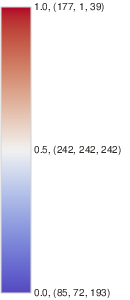

In [16]:
# Build arrays of scalars and colors
scalar_array = pandas.Series(numpy.linspace(0, 1, 1024))
sRGB_array = pandas.Series(diverging_color_map.map_scalar_array(scalar_array))
rgb_array = sRGB_array.apply(lambda color: color.get_value_tuple())

# Create toyplot colormap object
palette = toyplot.color.Palette(colors=rgb_array.values)
colormap = toyplot.color.LinearMap(palette=palette,
                                   domain_min=0, domain_max=1)

# Create toyplot display of colors.
canvas = toyplot.Canvas(width=130, height=300)
numberline = canvas.numberline(x1=16, x2=16, y1=-7, y2=7)
numberline.padding = 5
numberline.axis.spine.show = False
numberline.colormap(colormap,
                    width=30,
                    style={'stroke':'lightgrey'})

control_point_scalars = [0, 0.5, 1]
control_point_labels = []
for scalar in control_point_scalars:
    control_point_labels.append(
        '{:1.1f}, {}'.format(
            scalar,
            diverging_color_map.map_scalar(scalar).get_upscaled_value_tuple()))

numberline.axis.ticks.locator = \
    toyplot.locator.Explicit(locations=control_point_scalars,
                             labels=control_point_labels)
numberline.axis.ticks.labels.angle = -90
numberline.axis.ticks.labels.style = {'text-anchor':'start',
                                      'baseline-shift':'0%',
                                      '-toyplot-anchor-shift':'7px'
                                     }

toyplot.svg.render(canvas, 'bent-cool-warm.svg')

canvas

## Color Table Files

A convenience function that takes a column of RGB triples in a pandas dataframe, unzips it, and adds three columns to the data frame with the red, green, and blue values.

In [7]:
def unzip_rgb_triple(dataframe, column='RGB'):
    '''Given a dataframe and the name of a column holding an RGB triplet,
    this function creates new separate columns for the R, G, and B values
    with the same name as the original with '_r', '_g', and '_b' appended.'''
    # Creates a data frame with separate columns for the triples in the given column
    unzipped_rgb = pandas.DataFrame(dataframe[column].values.tolist(),
                                    columns=['r', 'g', 'b'])
    # Add the columns to the original data frame
    dataframe[column + '_r'] = unzipped_rgb['r']
    dataframe[column + '_g'] = unzipped_rgb['g']
    dataframe[column + '_b'] = unzipped_rgb['b']

Create several csv files containing color tables for this color map. We will create color tables of many different sizes from 8 rows to 1024. We also write out one set of csv files for "upscaled" color bytes (values 0-255) and another for floating point numbers (0-1).

In [8]:
for num_bits in xrange(3, 11):
    table_length = 2 ** num_bits
    color_table = pandas.DataFrame()
    color_table['scalar'] = numpy.linspace(0, 1, table_length)
    color_table['sRGBColor'] = \
        diverging_color_map.map_scalar_array(color_table['scalar'])
    color_table['RGB'] = \
        color_table['sRGBColor'].apply(lambda rgb: rgb.get_upscaled_value_tuple())
    color_table['sRGB'] = \
        color_table['sRGBColor'].apply(lambda rgb: rgb.get_value_tuple())
    unzip_rgb_triple(color_table, 'RGB')
    color_table.to_csv('bent-cool-warm-table-byte-{:04}.csv'.format(table_length),
                       index=False,
                       columns=['scalar', 'RGB_r', 'RGB_g', 'RGB_b'])
    unzip_rgb_triple(color_table, 'sRGB')
    color_table.to_csv('bent-cool-warm-table-float-{:04}.csv'.format(table_length),
                       index=False,
                       columns=['scalar', 'sRGB_r', 'sRGB_g', 'sRGB_b'],
                       header=['scalar', 'RGB_r', 'RGB_g', 'RGB_b'])

Create a color preset file for ParaView. Since ParaView 4.4, JSON files are supported, which makes it easy to export.

ParaView can interpolate in Lab space, but not LCH space. To approximate the curve we add several control points.

In [9]:
color_table = pandas.DataFrame()
color_table['scalar'] = numpy.linspace(0, 1, 15)
color_table['sRGBColor'] = \
    diverging_color_map.map_scalar_array(color_table['scalar'])
color_table['sRGB'] = \
    color_table['sRGBColor'].apply(lambda rgb: rgb.get_value_tuple())

RGBPoints = []
for index in xrange(0, color_table.index.size):
    RGBPoints.append(color_table['scalar'][index])
    RGBPoints.extend(color_table['sRGB'][index])
    
#RGBPoints

In [10]:
import json

file_descriptor = open('bent-cool-warm-paraview-colors.json', 'w')
json.dump([{'ColorSpace':'Lab',
            'Name':'Bent Cool Warm',
            'NanColor':[1.0,1.0,0.0],
            'RGBPoints':RGBPoints}],
          file_descriptor,
          indent=2)
file_descriptor.close()